#### Homography is a projective transformation. For a 2d projective transform, after homogenization of coordinates, we get a matrix with 8 unknowns. Hence we need 4 points in each image at minimum to compute the homography between them.
#### The four points will result in 8 equations, using which, we can solve the homography H $$Hx_i = x_i', i \in [1, 4]$$
#### H = $\begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$, setting one element $h_9 = 1$ leaves us with 8 degrees of freedom.
#### Now, to solve this system of equations
#### A = $\begin{bmatrix} x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1x_1' & -y_1x_1' \\ 0 & 0 & 0 & x_1 & y_1 & 1 & -x_1y_1' & -y_1y_1' \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_n & y_n & 1 & 0 & 0 & 0 & -x_nx_n' & -y_nx_n' \\ 0 & 0 & 0 & x_n & y_n & 1 & -x_ny_n' & -y_ny_n' \end{bmatrix}$ h = $\begin{bmatrix} h_1 \\ h_2 \\ h_3 \\ \vdots \\ h_8 \end{bmatrix}$ c = $\begin{bmatrix} x_1' \\ y_1' \\ \vdots \\ x_N' \\ y_N' \end{bmatrix}$

#### In our case, N = 4. Since A is then a square matric, we can solve for $$h = A^{-1}c$$

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mtplt
import numpy as np
import cv2

/home/kaushal/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Load and Display Images

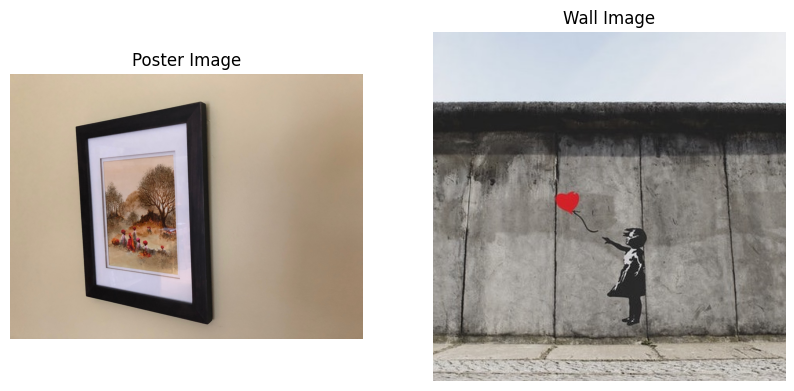

In [2]:
# Load images
poster_image = mpimg.imread('HW2_image1.jpg')
poster_image = np.rot90(poster_image, 2)
wall_image = mpimg.imread('HW2_image2.jpg')

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image (poster_image)
axs[0].imshow(poster_image, origin='upper')
axs[0].axis('off')  # Hide axes for the first image
axs[0].set_title('Poster Image')

# Display the second image (wall_image)
axs[1].imshow(wall_image, origin='upper')
axs[1].axis('off')  # Hide axes for the second image
axs[1].set_title('Wall Image')

# Show the plot with both images
plt.show()


## Choose Points in both Images for computing Homographies

In [3]:
# To allow an interactive display of images for clicking and manually getting the points.
mtplt.use('TkAgg')

# Number of points to choose
NUM_POINTS = 4

# Load images
poster_image = mpimg.imread('HW2_image1.jpg')
poster_image = np.rot90(poster_image, 2)
wall_image = mpimg.imread('HW2_image2.jpg')

# Click points on image1
plt.imshow(poster_image)
poster_points = plt.ginput(NUM_POINTS)
print(poster_points)

# Click points on image2
plt.imshow(wall_image)
wall_points = plt.ginput(NUM_POINTS)
print(wall_points)

[(924.6960569550932, 463.0969331872948), (531.7059145673605, 507.78477546549834), (563.2502738225631, 1088.726725082147), (953.6117196056956, 1137.3576122672507)]
[(446.26324344999045, 2.8807263686782676), (1.1859646377718036, 2.105330412559397), (-0.36482727446588115, 442.5302334880648), (445.4878474938715, 442.1425355100054)]


## Compute Homography

In [14]:
class Homography:
    def __init__(self):
        pass

    def compute_homography(self, source_points, destination_points):
        # Get number of points.
        num_points = len(source_points)

        # Construct the system of linear equations for computing homography of the form Ah = C
        # Assuming that the bottom right element of the homography is 1, giving 8 DOF.
        A = np.zeros((2*num_points, 8))

        C = np.zeros(2*num_points)
        C = C.reshape(-1, 1)

        # Populate A.
        for i in range(num_points):
            # Fill the 2*i th row
            x1 = source_points[i][0]
            y1= source_points[i][1]

            x2 = destination_points[i][0]
            y2 = destination_points[i][1]

            A[2*i, :] = [
                x1, y1, 1, 0, 0, 0, -x1*x2, -x2*y1
            ]

            C[2*i] = x2

            A[2*i+1, :] = [
                0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1
            ]

            C[2*i + 1] = y2

        h = np.linalg.inv((A.T@A))@(A.T@C)


        H = np.append(h, 1).reshape(3, 3)
        return H



    def place_source_image_into_destination(self, source_image, destination_image, dest_image_points, homography):
        # Create an image matrix of size equal to destination and warp the source image into it,
        # using the computed homography.
        warped_image = cv2.warpPerspective(source_image, homography,(destination_image.shape[1],destination_image.shape[0]))

        # Mask the poster image inside the polygon given by the selected points.
        masked_image = cv2.fillPoly(destination_image.copy(), [dest_image_points.astype(int)], 0)

        # # Bitwise or to combine the warped image and the masked image.
        overlayed_image = cv2.bitwise_or(warped_image, masked_image)

        return overlayed_image


## Map source image into destination image

4
Computed Homography =  [[ 5.87808139e-01  9.77640758e-02  5.30648576e+02]
 [-2.50359024e-01  1.36435367e+00  5.05061827e+02]
 [-3.18810423e-04  4.16518050e-05  1.00000000e+00]]
Computed Homography by CV2 function =  (array([[ 5.87808134e-01,  9.77640522e-02,  5.30648576e+02],
       [-2.50359019e-01,  1.36435362e+00,  5.05061827e+02],
       [-3.18810418e-04,  4.16517628e-05,  1.00000000e+00]]), array([[1],
       [1],
       [1],
       [1]], dtype=uint8))


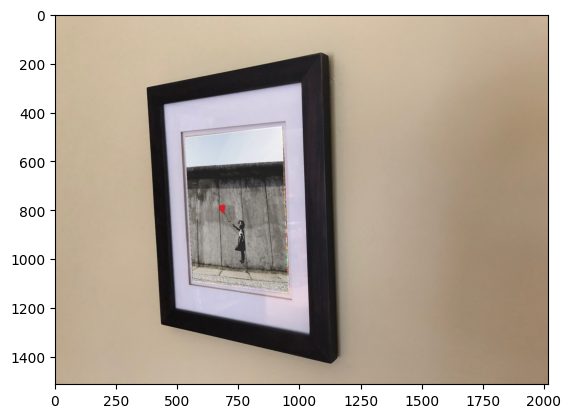

In [15]:
%matplotlib inline
homography = Homography()

H = homography.compute_homography(wall_points, poster_points)
print("Computed Homography = ", H)


# Convert points to numpy arrays
poster_points = np.array(poster_points, dtype='float32')
wall_points = np.array(wall_points, dtype='float32')

# Convert to the shape required by cv2.findHomography
poster_points_for_cv2 = poster_points.reshape(-1, 1, 2)
wall_points_for_cv2 = wall_points.reshape(-1, 1, 2)

overlayed_image = homography.place_source_image_into_destination(wall_image, poster_image, poster_points_for_cv2, H)
H1 = cv2.findHomography(wall_points, poster_points)
print("Computed Homography by CV2 function = ", H1)

plt.imshow(overlayed_image)
plt.show()